El dataset se puede descargar de https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
El dataset de Glove se puede descargar de https://nlp.stanford.edu/data/glove.6B.zip


IMPORTACIÓN DE LIBRERÍAS

---
Se importan las librerías para el modelo


In [1]:
import pandas as pd                                       #manipulación de datos
import numpy as np                                        #vectores multidimensionales gran cantidad de datos 
import re                                                 # expresiones regulares
import nltk                                               # procesamiento de texto
from nltk.corpus import stopwords                         #lista de palabras vacías

from numpy import array                                   #arreglo multidimensional
from keras.preprocessing.text import one_hot              #convertir texto en valores enteros
from keras.preprocessing.sequence import pad_sequences    #convertir secuencias en un array de 2D
from keras.models import Sequential                       #modelo neuronal con capas planas
from keras.layers.core import Activation, Dropout, Dense  #capas del modelo neuronal
from keras.layers import Flatten                          #aplana la entrada. No afecta el tamaño del lote.
from keras.layers import GlobalMaxPooling1D               #Reduce la muestra de la representación de entrada tomando el valor máximo sobre la dimensión de tiempo
from keras.layers.embeddings import Embedding             #capa de incrustaciones
from sklearn.model_selection import train_test_split      #divide arreglos y matrices en subconjuntos aleatorios de entrenamiento y prueba
from keras.preprocessing.text import Tokenizer            #vectoriza un corpus de texto, convirtiendo cada texto en una secuencia de números enteros

PARA ACCEDER AL GOOGLE DRIVE


---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Leer el dataset IMDB
movie_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv")
#Verificar si hay valores nulos
movie_reviews.isnull().values.any()
#Imprimir la forma del conjunto de datos
movie_reviews.shape

(50000, 2)

In [4]:
#Imprimir las 5 filas del conjunto de datos
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
#Ver un elemento del conjunto de datos
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

Como se observa el texto contiene signos de puntuación, corchetes y también algunas etiquetas HTML, se requiere entonces eliminar del texto estos elementos

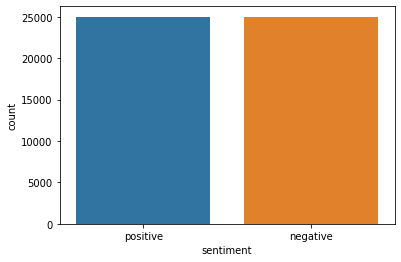

In [6]:
import seaborn as sns
#distribución de sentimientos positivos y negativos en el conjunto de datos.
sns.countplot(x='sentiment', data=movie_reviews)

PREPROCESAMIENTO DE DATOS

---
Primero se limpia el texto de signos de puntuación, espacios y etiquetas HTML. La función toma una cadena de texto como parámetro y luego realiza un preprocesamiento en la cadena para eliminar caracteres especiales y etiquetas HTML de la cadena.


In [7]:
def preprocess_text(sen):
    # remueve tags html
    sentence = remove_tags(sen)

    # remueve puntuaciones y números
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # remueve caracteres individuales
    #sentence = re.sub(r"s+[a-zA-Z]s+", ' ', sentence)

    # remueve múltiples espacios
    #sentence = re.sub(r's+', ' ', sentence)

    return sentence

In [8]:
# para operar con expresiones regulares
TAG_RE = re.compile(r'<[^>]+>')

#reemplaza cualquier cosa entre abrir y cerrar <>con un espacio vacío.
def remove_tags(text):
    return TAG_RE.sub('', text)

Se procesa previamente las reseñas y se  almacenan en una nueva lista X



In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
#Ver la cuarta reseña
X[3]

'Basically there s a family where a little boy  Jake  thinks there s a zombie in his closet   his parents are fighting all the time This movie is slower than a soap opera    and suddenly  Jake decides to become Rambo and kill the zombie OK  first of all when you re going to make a film you must Decide if its a thriller or a drama  As a drama the movie is watchable  Parents are divorcing   arguing like in real life  And then we have Jake with his closet which totally ruins all the film  I expected to see a BOOGEYMAN similar movie  and instead i watched a drama with some meaningless thriller spots   out of    just for the well playing parents   descent dialogs  As for the shots with Jake  just ignore them '

In [11]:
#convierte las etiquetas positivo 1 y negativo 0
y = movie_reviews['sentiment']
#función sin nombre. Puede tener cualquier número de argumentos, pero solo una expresión, que se evalúa y se devuelve. Debe tener un valor de retorno.
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Preparación de la capa de incrustación

---
El script anterior divide nuestros datos en un 80% para el conjunto de entrenamiento y un 20% para el conjunto de prueba.

A continuación el script para la capa de incrustación. La capa de incrustación convierte los datos textuales en datos numéricos y se utiliza como la primera capa para los modelos de aprendizaje profundo en Keras.

Como primer paso, se usa la Tokenizerclase del keras.preprocessing.textmódulo para crear un diccionario de palabra a índice. En el diccionario de palabra a índice, cada palabra del corpus se usa como clave, mientras que el índice único correspondiente se usa como valor para la clave.

In [12]:
#crea datasets de prueba y train, en un 80% para el conjunto de entrenamiento y un 20% para el conjunto de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
#crear diccionario de palabras a índice (incrustaciones de palabras)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
#crear un diccionario de palabra a índice
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
# Agregar 1 debido al índice 0 reservado y obtener el tamaño real del vocabulario
vocab_size = len(tokenizer.word_index) + 1
#define el tamaño máximo de las listas
maxlen = 100
#Cadena "post": rellena después de cada secuencia.
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Incrustaciones Glove


---

Se usan incrustaciones de GloVe para crear la matriz de características. En el siguiente script se cargan las incrustaciones de palabras GloVe y se crea un diccionario que contendrá palabras como claves y su correspondiente lista incrustada como valores.

In [15]:
# matriz de características con incrustaciones Glove
from numpy import array
from numpy import asarray                #convierte la entrada en una matriz
from numpy import zeros                  #retorna una nueva matriz de una forma y tipo dado, lenada con ceros

embeddings_dictionary = dict()
glove_file = open("/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype="float32")
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
#matriz de incrustación
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

CLASIFICACIÓN DE UN TEXTO CON UNA RED NEURONAL

---

In [17]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [18]:
#Compilar el modelo usando el optimizador Adam
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [19]:
#Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 3s 7ms/step - loss: 0.6040 - acc: 0.6712 - val_loss: 0.5398 - val_acc: 0.7275
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.5016 - acc: 0.7551 - val_loss: 0.5305 - val_acc: 0.7387
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4632 - acc: 0.7819 - val_loss: 0.5329 - val_acc: 0.7435
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4425 - acc: 0.7953 - val_loss: 0.5317 - val_acc: 0.7430
Epoch 5/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4277 - acc: 0.8044 - val_loss: 0.5352 - val_acc: 0.7439
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4154 - acc: 0.8130 - val_loss: 0.5388 - val_acc: 0.7435


In [20]:
#Resumen del modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [21]:
#Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 3s 8ms/step - loss: 0.4115 - acc: 0.8133 - val_loss: 0.5561 - val_acc: 0.7376
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4124 - acc: 0.8115 - val_loss: 0.5837 - val_acc: 0.7290
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3883 - acc: 0.8252 - val_loss: 0.5615 - val_acc: 0.7399
Epoch 4/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3837 - acc: 0.8290 - val_loss: 0.6022 - val_acc: 0.7246
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3816 - acc: 0.8315 - val_loss: 0.5778 - val_acc: 0.7330
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3775 - acc: 0.8316 - val_loss: 0.5821 - val_acc: 0.7344


In [22]:
#Para evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5943 - acc: 0.7280
Test Score: 0.594296395778656
Test Accuracy: 0.7279999852180481


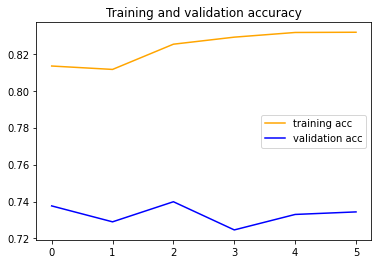

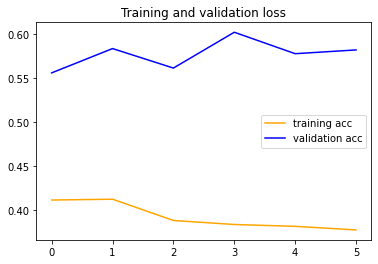

In [23]:
#Gráfica de la pérdida y precisión del modelo
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

HACER PREDICCIONES DE UNA SOLA INSTANCIA O SENTIMIENTO

---

In [24]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie  It s so unbelievable  A woman leaves her husband after many years of marriage  has a breakdown in front of a real estate office  What happens  The office manager comes outside and offers her a job    Hilarious  Next thing you know the two women are going at it  Yep  they re lesbians  Nothing rings true in this  Lifetime for Women with nothing better to do  movie  Clunky dialogue like  I don t want to spend the rest of my life feeling like I had a chance to be happy and didn t take it  doesn t help  There s a wealthy  distant mother who disapproves of her daughter s new relationship  A sassy black maid   unbelievable that in the year       a film gets made in which there s a sassy black maid  Hattie McDaniel must be turning in her grave  The woman has a husband who freaks out and wants custody of the snotty teenage kids  Sheesh  No cliche is left unturned 


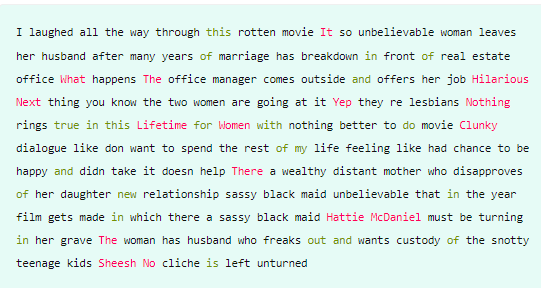

In [25]:
#Convertir la instancia en números
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

#rellenar la secuencia de entrada como se hizo con el corpus corpus
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
#predecir el sentimiento < a 0.5 --> negativo > a 0.5 positivo
model.predict(instance)

array([[0.34947792]], dtype=float32)